# Using SDGRegressor to Predict Crowdness at the Gym

I enjoy going to the gym, but I dislike it when it is crowded because I am unable to follow my plan at my own pace. I frequently have to wait for the machine I need to free up, making it nearly hard to follow my program.

As a result, I decided to create a prediction model using Machine Learning, namely a linear regressor using Stochastic Gradient Decsent.

Using a dataset of over 60,000 observations and 11 features such as day, hour, temperature, and other characteristics, I will build a model that can predict how many people will be at the gym on a specific day and time. That way, I'll be able to enjoy my exercise program without having to wait.

## Load the dataset

In [1]:
import pandas as pd
import numpy as np

gym = pd.read_csv("crowdness_gym_data.csv")
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


## Data Exploration and Cleaning
The dataset is fairly clean (there are no missing values). Now we want to ensure that we have all of the necessary data and that there is no noise or data that is irrelevant to our model.

In [2]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


This dataset contains over 60,000 observations about how many people were at the gym on a particular day and time. It contains 11 columns that contain the following information.

+ `number_people`: this is the number of people at the gym at each observation. This will be our target variable or label.
+ `date`: a string value with the specific date and time information.
+ `timestamp`: an integer (int), with the number of seconds since the start of the day (00:00).
+ `dayofweek`: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.
+ `is_weekend`: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.
+ `is_holiday`: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.
+ `temperature`: a float, defining the temperature during the day of the observation in Fahrenheit.
+ `isstartof_semester`: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.
+ `is_during_semester`: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.
+ `month: an integer` (int) defining the month of the year. 1 is equal to January, 12 is equal to December.
+ `hour`: an integer (int) for the hour of the day from 0 to 23.

We can get some more information with `.describe()` which gives us some basic statistics about the data.

In [3]:
gym.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


Every column appears to be fairly easy to understand. The `date` column, as an object, has no statistics, and the `timestamp` appears to be difficult to work with. Most of the other features appear to be good, with some binary features such as `is_holiday` and `is_weekend`.

At the moment, the only feature that I believe is certainly problematic is the `date` column; because it is an object and we already have other features that provide us with exact day and time, I will remove the date column entirely using.drop()

In [4]:
gym = gym.drop('date', axis=1)
gym.head()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,61211,4,0,0,71.76,0,0,8,17
1,45,62414,4,0,0,71.76,0,0,8,17
2,40,63015,4,0,0,71.76,0,0,8,17
3,44,63616,4,0,0,71.76,0,0,8,17
4,45,64217,4,0,0,71.76,0,0,8,17


## Visualization 
Let's take a closer look at the distribution of specific features.

I'll create a distribution chart for the `month`, `day`, and `hour`, as they are likely to have the most impact on the number of people.

<Figure size 1000x800 with 0 Axes>

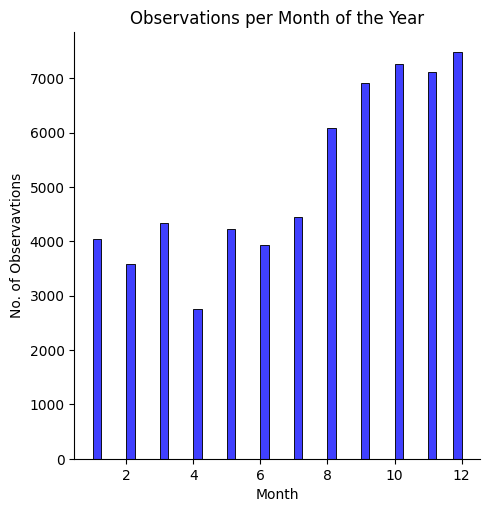

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))

sns.displot(gym['month'], color='b')
plt.title("Observations per Month of the Year")
plt.xlabel('Month')
plt.ylabel('No. of Observavtions')
plt.show()

Gym is mostly occupied at the last five month of the year. We also observed more observations at the beginning of the semester (August) than at the conclusion, most likely because everyone felt excited at the beginning and very busy at the end(March, April).

<Figure size 800x800 with 0 Axes>

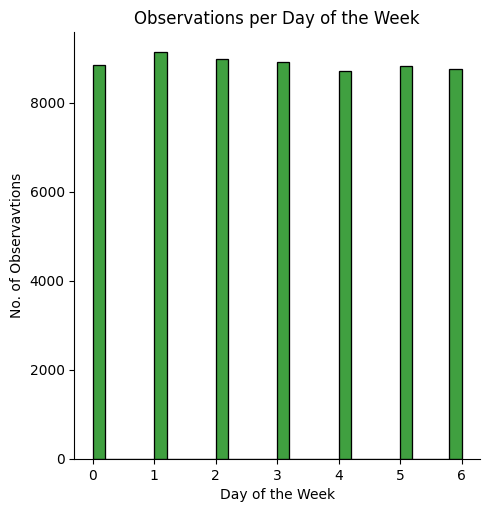

In [6]:
plt.figure(figsize=(8, 8))

sns.displot(gym['day_of_week'], color='g')
plt.title("Observations per Day of the Week")
plt.xlabel('Day of the Week')
plt.ylabel('No. of Observavtions')
plt.show()

There isn't much information here, except that the amount of observations for each day of the week isn't much different.

<Figure size 1000x800 with 0 Axes>

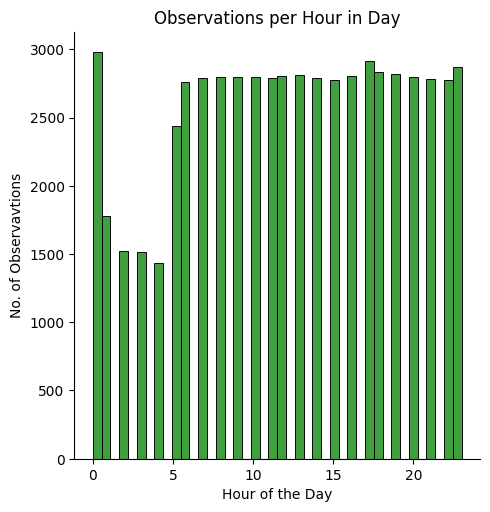

In [7]:
plt.figure(figsize=(10, 8))

sns.displot(gym['hour'], color='g')
plt.title("Observations per Hour in Day")
plt.xlabel('Hour of the Day')
plt.ylabel('No. of Observavtions')
plt.show()

This is far more interesting, but just in case, there are several observations in the early morning and mid-afternoon, which is expected, but the ones at midnight are unexpected. It appears that there are night owls going to the gym.

This is interesting, but since I am developing a model to forecast the `number of people` (target variable), I can gain more information by employing Bivariate Analysis, which means confronting two variables at the same time to determine whether there is a correlation between them.

Let's look at how the `month`, `day`, and `hour` relate to the amount of people.

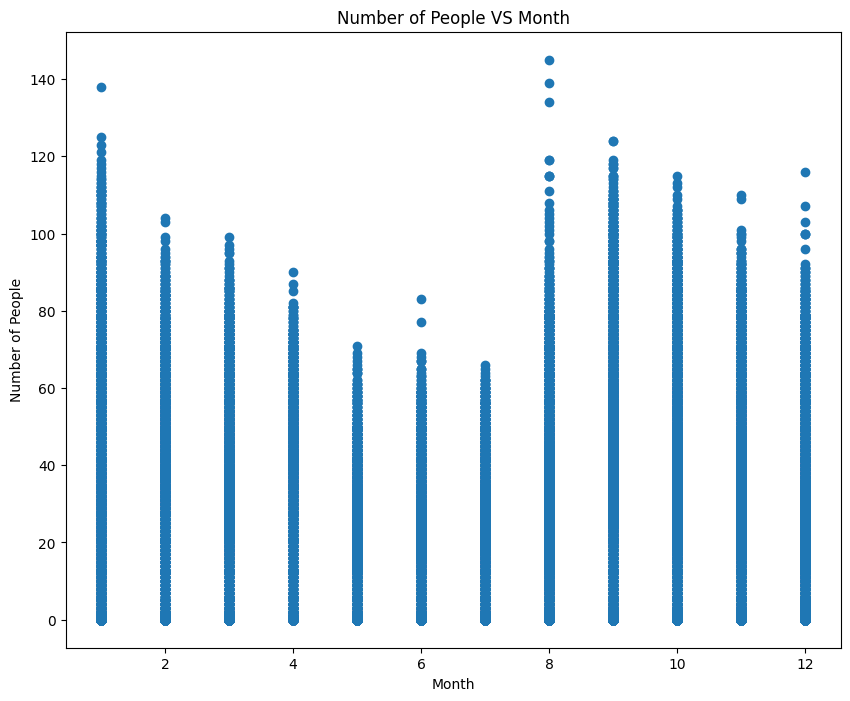

In [8]:
plt.figure(figsize=(10, 8))

plt.scatter(gym['month'], gym['number_people'])
plt.title("Number of People VS Month")
plt.xlabel('Month')
plt.ylabel('Number of People')
plt.show()

A more precise representation of the relationship. We can observe that August and January have the highest peak of people and that the beginning of the semester has higher peaks than the end.

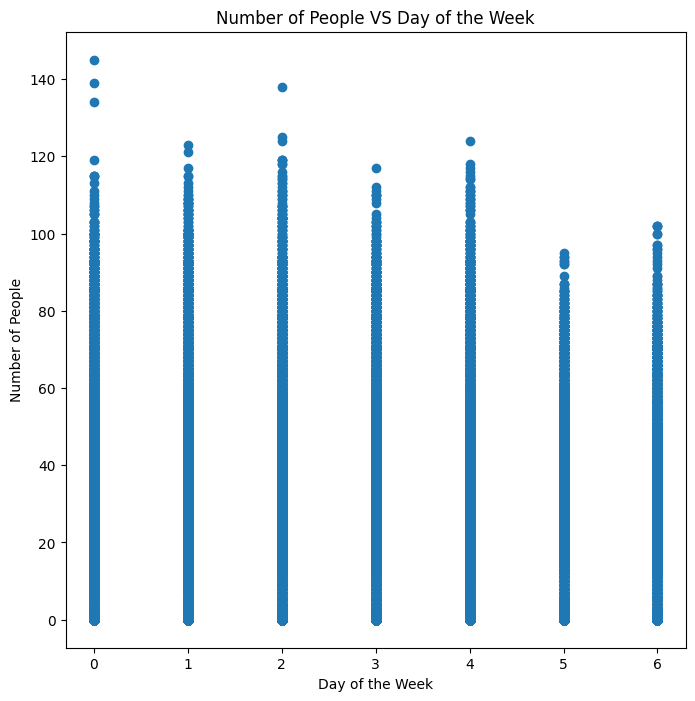

In [9]:
plt.figure(figsize=(8, 8))

plt.scatter(gym['day_of_week'], gym['number_people'])
plt.title("Number of People VS Day of the Week")
plt.xlabel('Day of the Week')
plt.ylabel('Number of People')
plt.show()

Here we can now see the largest peaks on Monday and Wednesday. And the lower peaks on Saturdays.

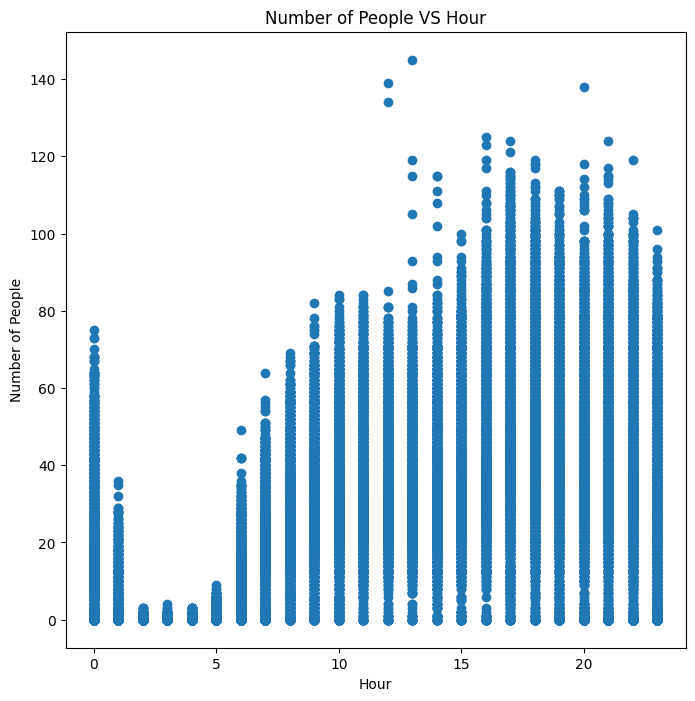

In [10]:
plt.figure(figsize=(8, 8))

plt.scatter(gym['hour'], gym['number_people'])
plt.title("Number of People VS Hour")
plt.xlabel('Hour')
plt.ylabel('Number of People')
plt.show()

Now we can see much more clearly that the highest peaks of people occur in the afternoon and evening, with unexpectedly large peaks late at night. Also, we witness very small peaks between 2 and 5 a.m.

I could go on about each variable, but to keep things simple, I'll use a heatmap to quickly visualize the relationship between each variable and our target variable (the number of people).

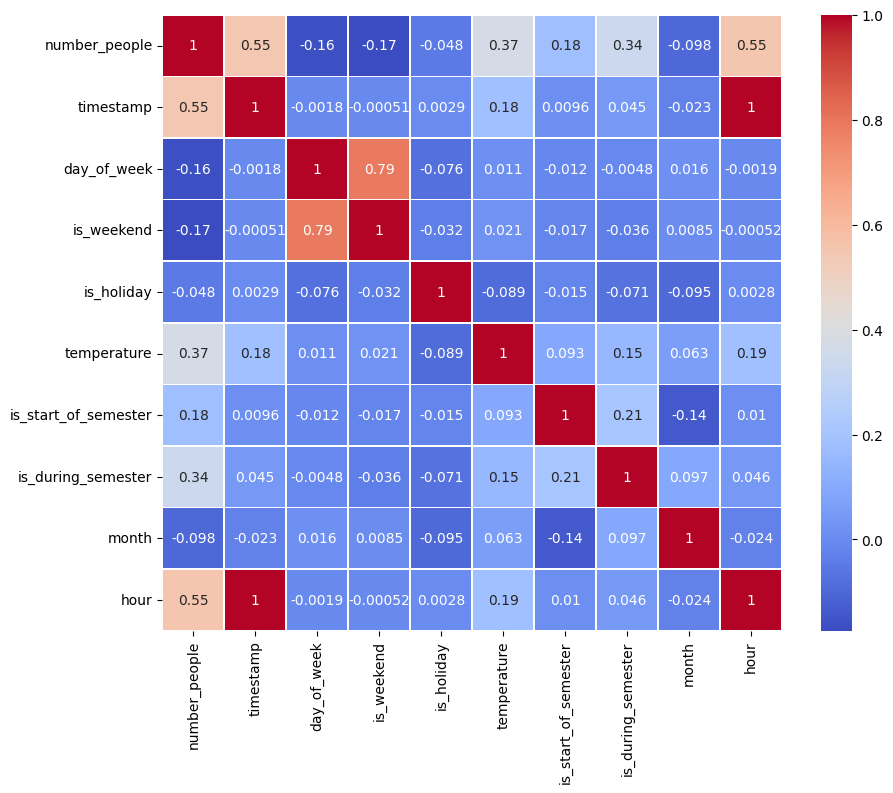

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(gym.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

This simply confirms our previous suspicions, that `temperature`, `hour` and `is_during_semester` variables are the most important.

Another thing, the `timestamp` seems to be redundant, since it has the same correlation as the hour, and we already have all the information on the month, day and time. So I will remove the timestamp column before moving on to building the model.

Also, check with `.head()` to make sure the column was removed.

In [12]:
gym = gym.drop('timestamp', axis=1)
gym.head()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,4,0,0,71.76,0,0,8,17
1,45,4,0,0,71.76,0,0,8,17
2,40,4,0,0,71.76,0,0,8,17
3,44,4,0,0,71.76,0,0,8,17
4,45,4,0,0,71.76,0,0,8,17


## Preparing to build our model with Stochastic Gradient Descent

We now have a clean dataset, which we have analyzed and removed any variables that we do not think important — or that contain too much noise for our model. 

The next step is to prepare the data for modeling.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

X = gym.drop(["number_people"], axis = 1)
y = gym["number_people"]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 20)

Build the model object with SGDRegressor. Setting the `learning rate` to `optimal`, the `loss function` to `hubber loss` and using `elasticnet` for the `penalty`.

The fitting the model with the training data. I set the random_state so as to be able to reproduce the training.

In [14]:
# model version 1

sgd_v1 = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber',  penalty='elasticnet', random_state = 20)
sgd_v1.fit(X_train, y_train)

y_pred_v1 = sgd_v1.predict(X_test)  # Predict labels

## Measure the Performance of the Model

Let's evaluate the performance of the model.

In [15]:
# The mean squared error
print(f"Mean squared error: {round( mean_squared_error(y_test, y_pred_v1),3)}")

# Explained variance score: 1 is perfect prediction
print(f"R2 score: {round(r2_score(y_test, y_pred_v1),3)}")

# Mean Absolute Error
print(f"Mean absolute error: { round(mean_absolute_error(y_test, y_pred_v1),3)}")

Mean squared error: 266.048
R2 score: 0.485
Mean absolute error: 12.206


Model 1 `Mean Squared Error` and `Mean Absolute Error` are fairly high (the closer to 0 the higher the accuracy), meaning the model is not incredibly accurate. With the `R2 Score` we can see there is a correlation of **0.485**, wich is not terrible, but not that good either since we want it to be as close to 1 as possible.

To try and improve the model, we can scale the features to normalize them from -1 to 1, this might help improve the model. For this, I will import the StandardScaler from Scikit Learn.

In [16]:
from sklearn.preprocessing import StandardScaler

# Model version 2

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

sgd_v2 = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber', penalty='elasticnet', random_state = 20)
sgd_v2.fit(X_train_scaled, y_train)

y_pred_v2 = sgd_v2.predict(X_test_scaled)  # Predict labels

Now we can build another model with the scaled data and see if we can improve it.

I am using the same `random_state` for consistent results.

In [17]:
# The mean squared error
print(f"Mean squared error: {round( mean_squared_error(y_test, y_pred_v2),3)}")

# Explained variance score: 1 is perfect prediction
print(f"R2 score: {round(r2_score(y_test, y_pred_v2),3)}")

# Mean Absolute Error
print(f"Mean absolute error: { round(mean_absolute_error(y_test, y_pred_v2),3)}")

Mean squared error: 257.326
R2 score: 0.502
Mean absolute error: 12.111


With the scaled data, the model performs slightly better, decreasing the `Mean Squared Error` and `Mean Absolute Error` and increasing the `R2 score` by `0.017`.

##  Visualize the Results

The best approach to see how our model performs is to visually represent it. Here is our first model's plot, which uses line plots with actual test data on the back and predicted data on the front. The spots where the plots converge are where the model performed well, whereas the points where the plots diverge indicate where the model performed poorly.

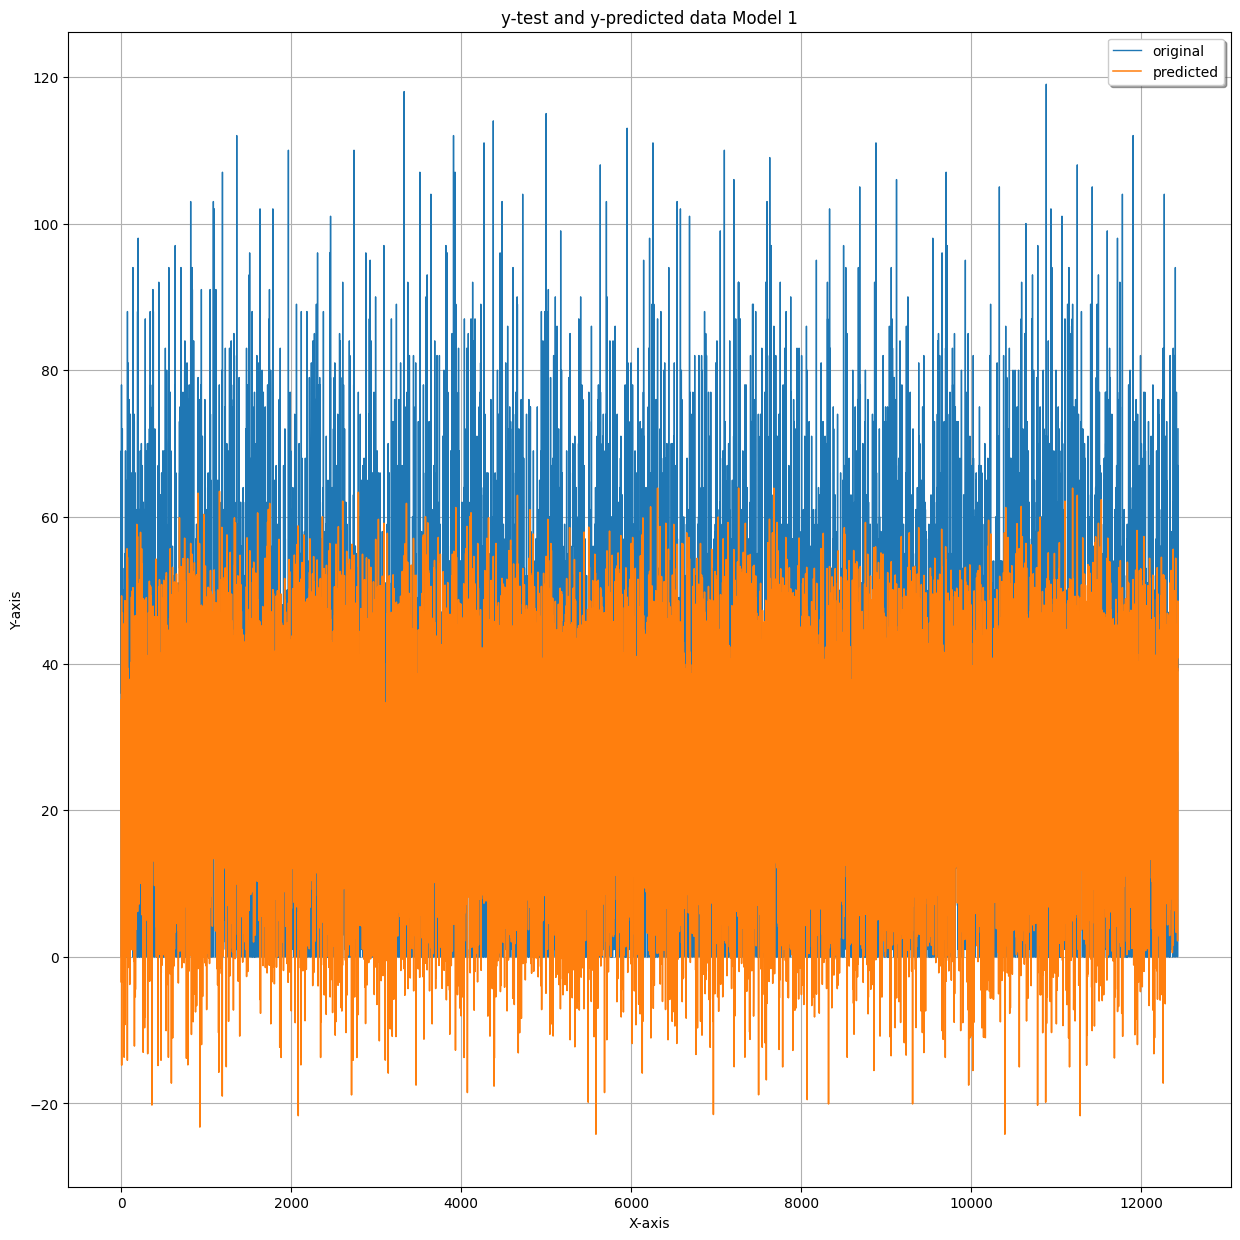

In [18]:
plt.figure(figsize=(15, 15))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred_v1, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data Model 1")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

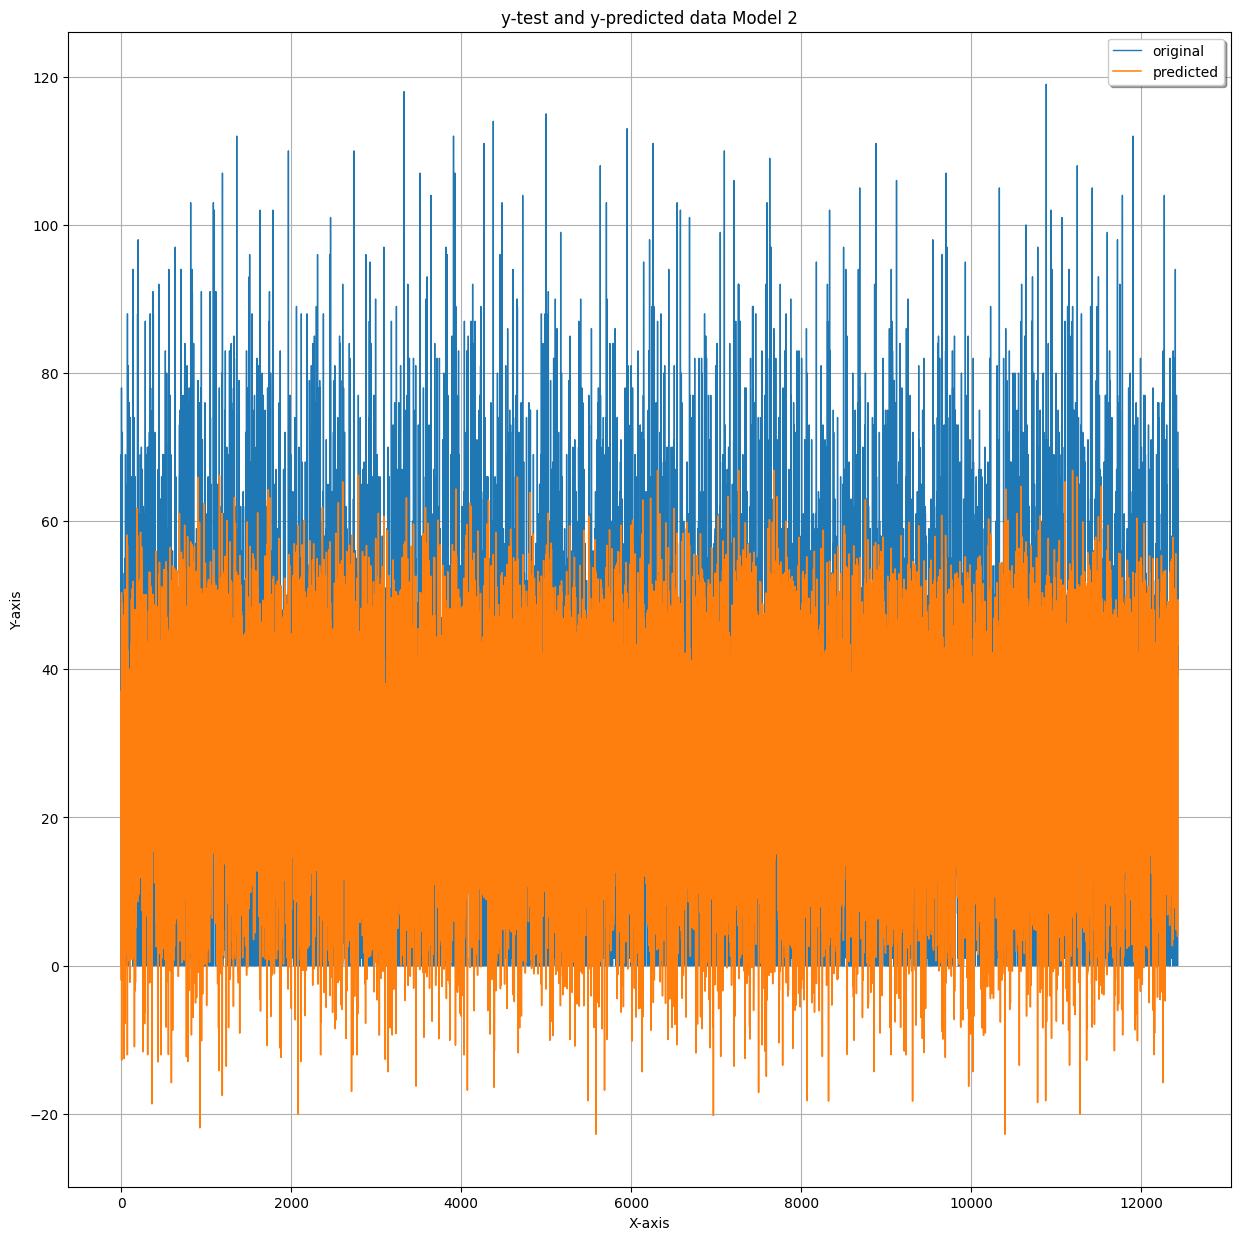

In [19]:
# Model v2

plt.figure(figsize=(15, 15))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred_v2, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data Model 2")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

## Conclusion

We can tell that there is plenty of space for improvement. However, a **linear regression model** with **Stochastic Gradient Descent** is a good place to start when developing such a prediction model.

We can improve the model by making a few changes. Regarding the data, I decided to eliminate the `timestamp` variable because I assumed it was redundant; yet, this redundancy may assist the model achieve more accuracy.

Also, modifying and testing other hyperparameters could be interesting, particularly changing the `loss function` from `huber` to `squared_epsilon_insensitive` and possibly experimenting with changing the `learning rate` and `penalty`.

Overall, based on the data and the model, any day at **5 a.m**. appears to be a safe bet for someone like me who enjoys going to the gym without being surrounded by people.


